<a href="https://colab.research.google.com/github/Aravinda89/Image-Classificatio-from-Scratch/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install fastai==2.0.15
# !pip install fastai2==0.0.30
# !pip install fastcore==1.0.16
# !pip install fastai --upgrade

! [ -e /content ] && pip install -Uqq fastai 

# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)

In [2]:
from fastai.vision.all import *

In [3]:
from torch import nn

from fastai.callback.hook import summary
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.callback.progress import ProgressCallback

from fastai.data.core import Datasets, DataLoaders, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, parent_label, ToTensor, IntToFloatTensor, Normalize

from fastai.layers import Flatten
from fastai.learner import Learner

from fastai.metrics import accuracy, CrossEntropyLossFlat

from fastai.vision.augment import CropPad, RandomCrop, PadMode
from fastai.vision.core import PILImageBW
from fastai.vision.utils import get_image_files

In [4]:
# Load data
path = untar_data(URLs.MNIST)

In [9]:
items = get_image_files(path)

In [12]:
items[0]

Path('/root/.fastai/data/mnist_png/training/3/9915.png')

In [17]:
items[:3]

(#3) [Path('/root/.fastai/data/mnist_png/training/3/9915.png'),Path('/root/.fastai/data/mnist_png/training/3/7976.png'),Path('/root/.fastai/data/mnist_png/training/3/50969.png')]

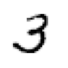

In [14]:
# Visualize image
im = PILImageBW.create(items[0])
im.show()

In [15]:
# Split train/test set
splits = GrandparentSplitter(train_name='training', valid_name='testing')

In [18]:
splits = splits(items)

In [25]:
splits[0][:5]

[0, 1, 2, 3, 4]

In [23]:
len(splits[0])

60000

In [24]:
len(splits[1])

10000

In [26]:
dsrc = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]], 
                  splits=splits)

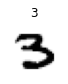

In [30]:
show_at(dsrc.train,5)

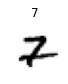

In [33]:
show_at(dsrc.valid,5000)

In [34]:
tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]

In [36]:
gpu_tfms = [IntToFloatTensor(), Normalize()]

In [37]:
dls = dsrc.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

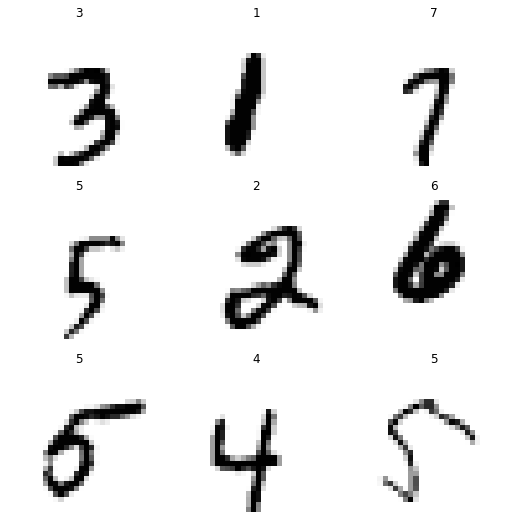

In [41]:
dls.show_batch()

In [42]:
xb, yb = dls.one_batch()

In [43]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [44]:
dls.c

10

Model

In [46]:
def conv(ni, nf): 
  return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [47]:
def bn(nf): 
  return nn.BatchNorm2d(nf)

In [48]:
def ReLU(): 
  return nn.ReLU(inplace=False)

In [49]:
model = nn.Sequential(
                      conv(1, 8),
                      bn(8),
                      ReLU(),
                      conv(8, 16),
                      bn(16),
                      ReLU(),
                      conv(16,32),
                      bn(32),
                      ReLU(),
                      conv(32, 16),
                      bn(16),
                      ReLU(),
                      conv(16, 10),
                      bn(10),
                      Flatten()
)

In [50]:
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Flatten(full=False)
)

In [51]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [52]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 14 x 14   
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 7 x 7    
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 4 x 4    
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________

Learning Rate finder

SuggestedLRs(valley=0.005248074419796467)

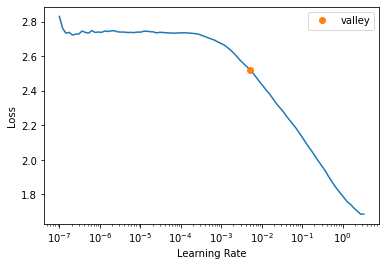

In [53]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(3, lr_max=0.005248074419796467)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored